In [42]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
import os
from sklearn import tree
from sklearn import ensemble
import math
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import pickle
import pulp
import string

In [6]:
def parse_one_file1(file_path,teams_path,payers_raw_path,columns_for_drop,only_last_week,last_weeks):
  df = pd.read_csv(file_path)
  df = df.drop(columns=columns_for_drop)
  #print('uso')

  teams = pd.read_csv(teams_path)
  columns_teams = list(teams.columns)
  columns_teams.remove('id')
  columns_teams.remove('strength')
  teams = teams.drop(columns=columns_teams)


  payers_raw = pd.read_csv(payers_raw_path)
  columns_players_raw = list(payers_raw.columns)
  columns_players_raw.remove('id')
  columns_players_raw.remove('element_type')
  payers_raw = payers_raw.drop(columns=columns_players_raw)


  df = pd.merge(df, teams, left_on='opponent_team', right_on='id', how='left').drop(['opponent_team','id'],axis=1)
  df = pd.merge(df, payers_raw, left_on='element', right_on='id', how='left').drop(['element','id'],axis=1)
  df['minutes'] = np.where(df['minutes']>=60, 1, 0)

  df_element_type = df['element_type']
  df_strength = df['strength']
  df_total_points = df['total_points']
  df_was_home = df['was_home']
  dfs_only_last_week = df[only_last_week]
  df_left = df.drop(columns=(['element_type','strength','was_home','total_points']+only_last_week))
  df_right = pd.concat([df_element_type,df_strength, df_was_home,df_total_points], axis=1)

  #     print(df_left.head)
  columns_left = df_left.columns
  columns_middle = dfs_only_last_week.columns
  columns_right = df_right.columns

  new_data = []
  data = df_left.to_numpy()

  n = data.shape[0]
  d = (last_weeks)*((last_weeks+1)/2)
  for i in range(last_weeks,n):
      u = 1
      inner_array = np.copy(data[i-last_weeks])
      inner_array = inner_array*(u/d)
      for j in range(i-last_weeks+1,i):
          u+=1
          inner_array += data[j]*(u/d)
          
  #         inner_array /= last_weeks
      inner_array = np.append(inner_array,np.array([x for x in dfs_only_last_week.iloc[i-1]]))
      inner_array = np.append(inner_array,np.array([df_right['element_type'][i],df_right['strength'][i],df_right['was_home'][i],df_right['total_points'][i]]))
      new_data.append(inner_array)
  columns = np.append(np.array(columns_left),np.array(columns_middle))
  columns = np.append(np.array(columns),np.array(columns_right))
  return pd.DataFrame(new_data,columns=columns)

In [7]:
def parse_data(root_path,teams_path,payers_raw_path,columns_for_drop,only_last_week,last_weeks = 5):
    data = pd.DataFrame()
    for root, subdirs, files in os.walk(root_path):
        file_path = None
        for file in files:
          if(file == "gw.csv"):
            file_path = os.path.join(root,file)
            #print(file_path)
            new_data = parse_one_file1(file_path,teams_path,payers_raw_path,columns_for_drop,only_last_week,last_weeks)
            data = pd.concat([new_data,data],ignore_index=True)
    return data

In [ ]:
!unrar x "./players.rar" "."

In [9]:
columns_for_drop = ['bps','fixture','ict_index','kickoff_time','round','transfers_in','transfers_out']
only_last_week = ['creativity','influence','threat']
data = parse_data('./players/','teams.csv','players_raw.csv',columns_for_drop,only_last_week,5)
data.head()

,assists,bonus,clean_sheets,goals_conceded,goals_scored,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,transfers_balance,value,yellow_cards,creativity,influence,threat,element_type,strength,was_home,total_points
0,0.0,0.0,0.000000,0.8,0.0,0.266667,0.0,0.0,0.0,0.0,0.0,16403.200000,2.533333,1.800000,-968.333333,44.400000,0.266667,0.0,0.0,0.0,2.0,3.0,0.0,0.0
1,0.0,0.0,0.000000,0.6,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,16097.066667,2.266667,1.666667,-869.333333,44.200000,0.200000,0.0,0.0,0.0,2.0,3.0,1.0,0.0
2,0.0,0.0,0.000000,0.4,0.0,0.133333,0.0,0.0,0.0,0.0,0.0,15638.333333,1.600000,1.800000,-795.533333,44.066667,0.133333,0.0,0.0,0.0,2.0,5.0,0.0,6.0
3,0.0,0.0,0.333333,0.2,0.0,0.400000,0.0,0.0,0.0,0.0,0.0,15121.000000,1.666667,1.200000,-748.933333,44.000000,0.066667,0.3,9.0,6.0,2.0,3.0,1.0,0.0
4,0.0,0.0,0.266667,0.0,0.0,0.266667,0.0,0.0,0.0,0.0,0.0,15302.600000,1.333333,1.000000,-106.133333,43.666667,0.000000,0.0,0.0,0.0,2.0,3.0,0.0,1.0


In [ ]:
# for u in np.unique(data['total_points']):
#     print(u,sum(u == data['total_points']))

In [10]:
x = pd.get_dummies(data,columns=['was_home','element_type'])
x = data.drop(columns=['total_points'])

In [11]:
y = data['total_points']

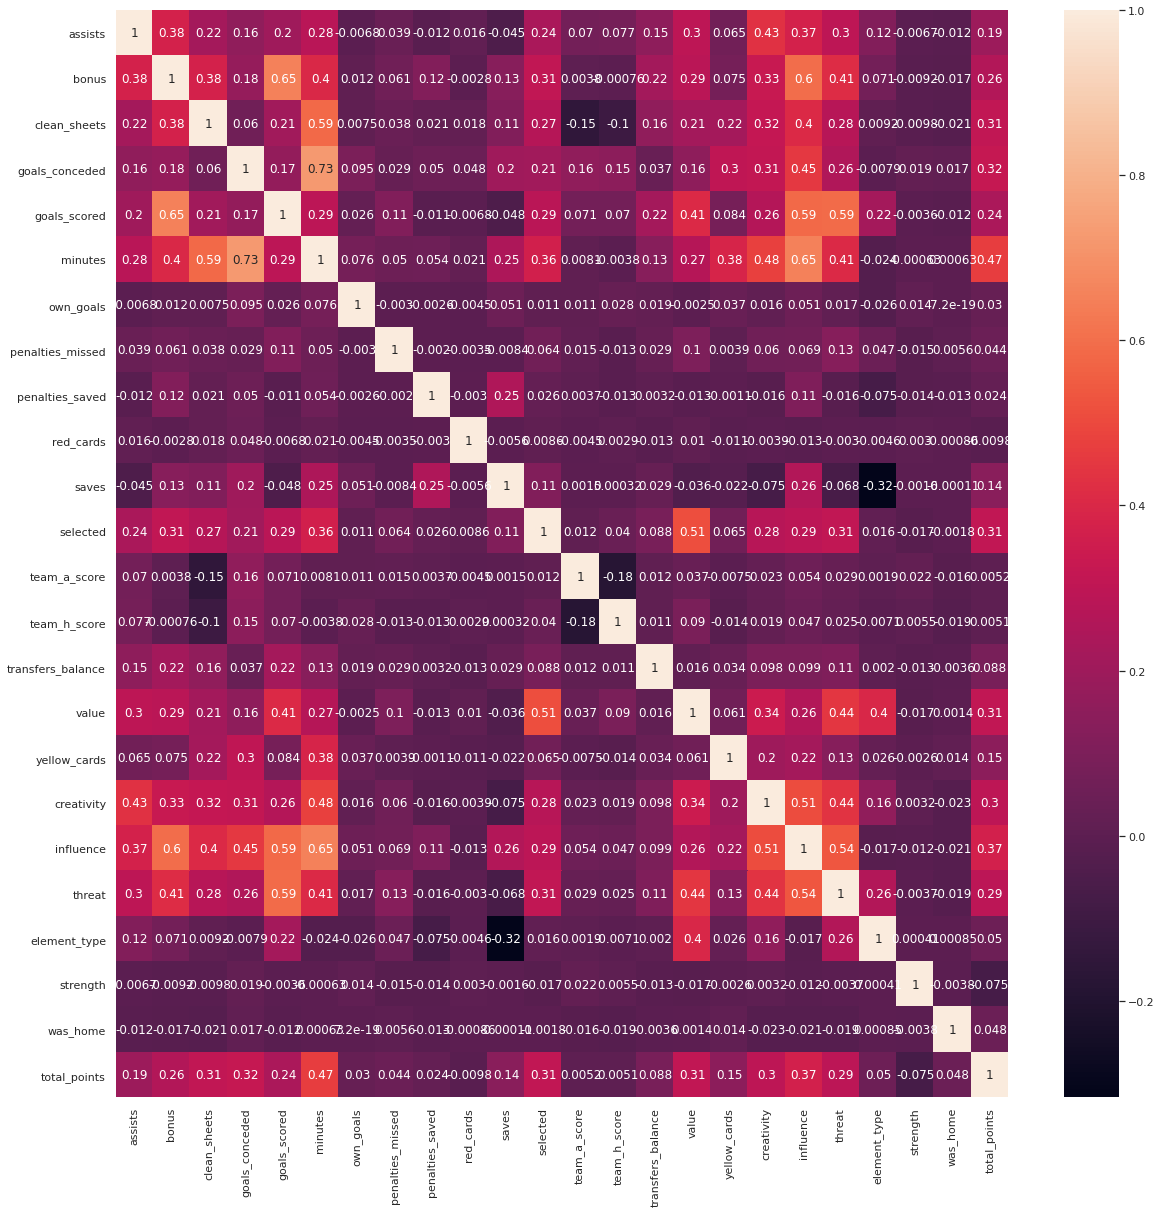

In [97]:
corrmax = data.corr()
import seaborn as sns; sns.set()
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corrmax, annot = True)

In [12]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.25)

scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [13]:
def selectParamsAndEvaluateConfigurations(model, model_name, params):
  grid_model = model_selection.GridSearchCV(model, param_grid=params, scoring='r2', return_train_score=True, cv = 5)
  grid_model.fit(x_train_scaled, y_train)

  #with open('models/' + model_name_ + '.sav','wb') as pickle_grid_model:
  # pickle.dump(grid_model, pickle_grid_model)

  print("Model name: " + model_name)
  print(grid_model.best_score_)
  print(grid_model.best_params_)
  print("-----------------------------")

#LinearnaRegresija

In [103]:
lr = linear_model.LinearRegression()
lr.fit(x_train_scaled, y_train)
y_pred = lr.predict(x_test_scaled)
print('R2: ' + str(metrics.r2_score(y_test, y_pred)))
print('MSE: ' + str(metrics.mean_squared_error(y_test, y_pred)))

R2: 0.2812197797778696
MSE: 4.354098310475768


#GBM

In [81]:
GBM_model = GradientBoostingRegressor()

params_gbm = {
    "n_estimators": [50, 100, 200, 500, 1000, 5000],
    "max_features": [i for i in range(1, 20, 2)],
    "subsample": [0.1, 1.0],
    "validation_fraction":[0.2],
    "n_iter_no_change": [100]
}

selectParamsAndEvaluateConfigurations(GBM_model, "GradientBoostingRegressor", params_gbm)
#Model name: GradientBoostingRegressor - bez only last week
#0.28528190891727345
#{'max_features': 3, 'n_estimators': 50, 'n_iter_no_change': 100, 'subsample': 1.0, 'validation_fraction': 0.2}

#Model name: GradientBoostingRegressor - sa OLW
#0.2850303130073252
#{'max_features': 11, 'n_estimators': 50, 'n_iter_no_change': 100, 'subsample': 1.0, 'validation_fraction': 0.2}

Model name: GradientBoostingRegressor
0.2850303130073252
{'max_features': 11, 'n_estimators': 50, 'n_iter_no_change': 100, 'subsample': 1.0, 'validation_fraction': 0.2}
-----------------------------


#MLP

In [ ]:
params_mlp = {
    "solver": ['sgd', 'adam'],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "learning_rate_init": [0.0001, 0.001, 0.01, 0.1, 1],
    "max_iter":[300, 500],
    "early_stopping": [True],
    "verbose": [False]
}

mlp_model = MLPRegressor()

selectParamsAndEvaluateConfigurations(mlp_model, "MLPRegressor", params_mlp)

#Model name: MLPRegressor - bez OLW
#0.27905076128761763
#{'alpha': 0.01, 'early_stopping': True, 'learning_rate_init': 0.0001, 'max_iter': 300, 'solver': 'adam', 'verbose': False}

#Model name: MLPRegressor - sa OLW
#0.2782348040723388
#{'alpha': 0.001, 'early_stopping': True, 'learning_rate_init': 0.001, 'max_iter': 300, 'solver': 'sgd', 'verbose': False}

#RandomForestRegressor

In [83]:
RFR_model = RandomForestRegressor()

params_rfr = {
    "n_estimators": [100*i for i in range(1, 4)],
    "max_depth": [10*i for i in range(1, 6)],
}

selectParamsAndEvaluateConfigurations(RFR_model, "RandomForestRegressor", params_rfr)
#Model name: RandomForestRegressor - bez OLS
#0.2748841055665351
#{'max_depth': 10, 'n_estimators': 300}

#Model name: RandomForestRegressor - SA OLW
#0.2722645502627851
#{'max_depth': 10, 'n_estimators': 300}

Model name: RandomForestRegressor
0.2722645502627851
{'max_depth': 10, 'n_estimators': 300}
-----------------------------


#AdaBoost

In [84]:
from sklearn import tree
from sklearn import ensemble
 
Ada_model = ensemble.AdaBoostRegressor(base_estimator=tree.DecisionTreeRegressor(max_depth=200))
 
params_ada = {
    "n_estimators": [100*i for i in range(1, 6)]
}

selectParamsAndEvaluateConfigurations(Ada_model, "AdaBoostRegressor", params_ada)
#Model name: AdaBoostRegressor
#0.21949254913951907
#{'n_estimators': 300}

Model name: AdaBoostRegressor
0.2137326421701517
{'n_estimators': 500}
-----------------------------


#XGBoost

In [85]:
parameters_xgb = {'objective':['reg:squarederror'],
              'learning_rate': [0.05, .07, 0.3],
              'max_depth': [3,10],
              'min_child_weight': [1, 4],
              'silent': [1],
              'subsample': [1],
              'colsample_bytree': [0.7, 1],
              'n_estimators': [100, 300]}

xg_model = xgboost.XGBRegressor()

selectParamsAndEvaluateConfigurations(xg_model, "XGBRegressor", parameters_xgb)
#Model name: XGBRegressor
#0.2893726231011501
#{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 1}

Model name: XGBRegressor
0.28575641991436673
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 1}
-----------------------------


#SVR

In [89]:
from sklearn.svm import SVR

params_svr = {
    'C': [10**i for i in range(-1, 2)], 
    'gamma': [10**i for i in range(-2, 2)],
    'kernel': ['rbf']
}

svr_model = SVR()

selectParamsAndEvaluateConfigurations(svr_model, "SVR", params_svr)
#Model name: SVR - bez only last week
#0.2097476676414134
#{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Model name: SVR
0.2056257776130756
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
-----------------------------


#Neuronske mreze (iz nekog razloga su se bas lose pokazale?)

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout

NN_model = Sequential()

NN_model.add(Dense(128, kernel_initializer='normal',input_dim = x_train_scaled.shape[1], activation='relu'))

NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.5))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

NN_model.add(Dense(1, kernel_initializer='normal'))

NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

checkpoint_name = 'checkpoints/Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

NN_model.fit(x_train_scaled, y_train, epochs=200, batch_size=32, validation_split = 0.2)

y_pred_nn = NN_model.predict(x_test_scaled)
metrics.r2_score(y_test, y_pred_nn), metrics.mean_squared_error(y_test, y_pred_nn)

#         R2                    MSE

#(-0.04367001986856445, 6.182335960119634) bez only last week
#(0.09056526877919813, 5.571833197767964) sa only last week

#Treniranje i cuvanje najboljeg modela

In [15]:
GBM_model_final = GradientBoostingRegressor(max_features= 11, n_estimators= 50, n_iter_no_change= 100, subsample= 1.0, validation_fraction= 0.2)
GBM_model_final.fit(x_train_scaled, y_train)


with open('models/GBM_model.sav','wb') as final_model:
  pickle.dump(GBM_model_final, final_model)

#Linear programming - izbor najboljeg tima

In [49]:
def get_player_instance(file_path,teams_path,payers_raw_path,columns_for_drop,only_last_week,last_weeks):
    #print("GPI")
    df = pd.read_csv(file_path)
    df = df.drop(columns=columns_for_drop)
    if(df.shape[0] - last_weeks - 1 < 0):
        return pd.DataFrame(),0,0
    teams = pd.read_csv(teams_path)
    columns_teams = list(teams.columns)
    columns_teams.remove('id')
    columns_teams.remove('strength')
    teams = teams.drop(columns=columns_teams)
    
    
    payers_raw = pd.read_csv(payers_raw_path)
    columns_players_raw = list(payers_raw.columns)
    columns_players_raw.remove('id')
    columns_players_raw.remove('element_type')
    payers_raw = payers_raw.drop(columns=columns_players_raw)
    
    
    df = pd.merge(df, teams, left_on='opponent_team', right_on='id', how='left').drop(['opponent_team','id'],axis=1)
    df = pd.merge(df, payers_raw, left_on='element', right_on='id', how='left').drop(['element','id'],axis=1)
    df['minutes'] = np.where(df['minutes']>=60, 1, 0)

    df_element_type = df['element_type']
    df_strength = df['strength']
    df_total_points = df['total_points']
    df_was_home = df['was_home']
    dfs_only_last_week = df[only_last_week]
    df_left = df.drop(columns=(['element_type','strength','was_home','total_points']+only_last_week))
    df_right = pd.concat([df_element_type,df_strength, df_was_home,df_total_points], axis=1)

    
    columns_left = df_left.columns
    columns_middle = dfs_only_last_week.columns
    columns_right = df_right.columns
    
    data = df_left.to_numpy()
    n = data.shape[0]
    
    instance = np.copy(data[n-last_weeks-1])
    u = 1
    d = (last_weeks)*((last_weeks+1)/2)
    instance = instance * (u/d)
    for i in range(n-last_weeks,n-1):
        u+=1
        instance += data[i]*(u/d)
    instance = np.append(instance,np.array([x for x in dfs_only_last_week.iloc[n-2]]))
    instance = np.append(instance,np.array([df_right['element_type'][n-1],df_right['strength'][n-1],df_right['was_home'][n-1]]))
    columns = np.append(np.array(columns_left),np.array(columns_middle))
    columns = np.append(np.array(columns),np.array(columns_right))
    return (pd.DataFrame(instance.reshape(-1, len(instance)),columns=columns[:len(columns)-1]),df_left['value'][n-1]/10,df_right['element_type'][n-1])

In [50]:
def predict_points_for_players(root_path,teams_path,payers_raw_path,columns_for_drop,only_last_week,last_weeks = 5):
    #print("PPFP")
    skip_first = True
    playersFWD = {}
    playersMID = {}
    playersDEF = {}
    playersGLK = {}
    model = None
    with open('models/GBM_model.sav','rb') as pickle_model_forest:
        model = pickle.load(pickle_model_forest)
    for root, subdirs, files in os.walk(root_path):
        file_path = None
        if(skip_first):
            skip_first = False
            continue
        for file in files:
            if(file == 'gw.csv'):
                file_path = os.path.join(root,file)
        name = '_'.join(root.split('/')[len(root.split('/'))-1].split(' '))
        name = name.replace('-','_')
        #print(name)
        
        if(file_path != None):
            instance,value,pos = get_player_instance(file_path,teams_path,payers_raw_path,columns_for_drop,only_last_week,last_weeks)
            if(instance.empty):
                continue
        
            points = model.predict(instance)[0]
            if(pos == 1):
                playersGLK[name] = {'price':value,'points':points,'position':'GLK'}
            elif(pos == 2):
                playersDEF[name] = {'price':value,'points':points,'position':'DEF'}
            elif(pos == 3):
                playersMID[name] = {'price':value,'points':points,'position':'MID'}
            elif(pos == 4):
                playersFWD[name] = {'price':value,'points':points,'position':'FWD'}
            
    return playersGLK,playersDEF,playersMID,playersFWD


In [52]:
columns_for_drop = ['bps','fixture','ict_index','kickoff_time','round','transfers_in','transfers_out']
only_last_week = ['creativity','influence','threat']
playersGLK,playersDEF,playersMID,playersFWD = predict_points_for_players('players/','teams.csv','players_raw.csv',columns_for_drop,only_last_week,2)
all_players = {}
all_players.update(playersFWD)
all_players.update(playersMID)
all_players.update(playersDEF)
all_players.update(playersGLK)
#print(all_players)

In [ ]:
pip install pulp

In [53]:
import pulp

variablesFWD = [pulp.LpVariable(p, cat='Binary') for p in playersFWD]
variablesMID = [pulp.LpVariable(p, cat='Binary') for p in playersMID]
variablesDEF = [pulp.LpVariable(p, cat='Binary') for p in playersDEF]
variablesGLK = [pulp.LpVariable(p, cat='Binary') for p in playersGLK]
all_variables = variablesFWD+variablesMID+variablesDEF+variablesGLK
players_sum = []
players_price = []
for v in all_variables:
    players_sum.append(all_players[str(v)]['points']*v)
    players_price.append(all_players[str(v)]['price']*v)
best_players_15 = pulp.LpProblem("Best_FPL_players_15", pulp.LpMaximize)
best_players_15 += pulp.lpSum(players_sum)
best_players_15 += pulp.lpSum(players_price) <= 100.00
best_players_15 += pulp.lpSum(variablesFWD) == 3
best_players_15 += pulp.lpSum(variablesMID) == 5
best_players_15 += pulp.lpSum(variablesDEF) == 5
best_players_15 += pulp.lpSum(variablesGLK) == 2
status_15 = best_players_15.solve()
pulp.LpStatus[status_15]
selected_15 = []
for p in all_variables:
    if(pulp.value(p) == 1):
        selected_15.append(str(p))
for s in selected_15:
    print(s,all_players[s])

Che_Adams_437 {'price': 5.3, 'points': 8.995403782119642, 'position': 'FWD'}
Tammy_Abraham_460 {'price': 7.3, 'points': 8.584137666122148, 'position': 'FWD'}
Anthony_Gordon_561 {'price': 4.5, 'points': 8.505232873285225, 'position': 'FWD'}
Bernardo_Mota_Veiga_de_Carvalho_e_Silva_218 {'price': 7.6, 'points': 8.52927126131609, 'position': 'MID'}
Bukayo_Saka_541 {'price': 4.7, 'points': 8.73158309145785, 'position': 'MID'}
Demarai_Gray_175 {'price': 5.0, 'points': 8.311173358507146, 'position': 'MID'}
Riyad_Mahrez_217 {'price': 8.6, 'points': 8.63665290255179, 'position': 'MID'}
Ayoze_Pérez_265 {'price': 6.0, 'points': 8.57808128939046, 'position': 'MID'}
Eric_Garcia_544 {'price': 4.5, 'points': 8.854275211508272, 'position': 'DEF'}
Aaron_Wan_Bissaka_122 {'price': 5.5, 'points': 8.45984924826029, 'position': 'DEF'}
Oleksandr_Zinchenko_206 {'price': 5.2, 'points': 9.555766730522464, 'position': 'DEF'}
Luke_Thomas_660 {'price': 4.0, 'points': 8.704419976156291, 'position': 'DEF'}
John_Stone

In [54]:
def get_team_11(playersGLK,playersDEF,playersMID,playersFWD,deff,mid,fwd,price):
    all_players = {}
    all_players.update(playersFWD)
    all_players.update(playersMID)
    all_players.update(playersDEF)
    all_players.update(playersGLK)
    variablesFWD = [pulp.LpVariable(p, cat='Binary') for p in playersFWD]
    variablesMID = [pulp.LpVariable(p, cat='Binary') for p in playersMID]
    variablesDEF = [pulp.LpVariable(p, cat='Binary') for p in playersDEF]
    variablesGLK = [pulp.LpVariable(p, cat='Binary') for p in playersGLK]
    all_variables = variablesFWD+variablesMID+variablesDEF+variablesGLK
    players_sum = []
    players_price = []
    for v in all_variables:
        players_sum.append(all_players[str(v)]['points']*v)
        players_price.append(all_players[str(v)]['price']*v)
    best_players = pulp.LpProblem("Best_FPL_players_"+str(deff)+str(mid)+str(fwd), pulp.LpMaximize)
    best_players += pulp.lpSum(players_sum)
    best_players += pulp.lpSum(players_price) <= price
    best_players += pulp.lpSum(variablesFWD) == fwd
    best_players += pulp.lpSum(variablesMID) == mid
    best_players += pulp.lpSum(variablesDEF) == deff
    best_players += pulp.lpSum(variablesGLK) == 1
    status = best_players.solve()
    pulp.LpStatus[status]
    selected = []
    for p in all_variables:
        if(pulp.value(p) == 1):
            selected.append(str(p))
    return selected

In [55]:
def choose_best_formation(formations):
    teams = []
    price = 85.0
    for f in formations:
        deff = int(f/100)
        mid = int(f/10)%10
        fwd = f%10
        team = get_team_11(playersGLK,playersDEF,playersMID,playersFWD,deff,mid,fwd,price)
        teams.append((team,''+str(deff)+'-'+str(mid)+'-'+str(fwd)))
    best_formation = None
    best_formation_points = None
    best_formation_label = None
    for (t,l) in teams:
        team_p = 0.0
        for s in t:
            team_p += all_players[s]['points']
        if(best_formation == None):
            best_formation = t
            best_formation_points = team_p
            best_formation_label = l
        elif(best_formation_points < team_p):
            best_formation = t
            best_formation_points = team_p
            best_formation_label = l

    print('Best team')
    print(best_formation_label)
    for s in best_formation:
        print(s,all_players[s])

    print()
    print('All teams')
    for (t,l) in teams:
        print(l)
        for s in t:
            print(s,all_players[s])
        print()

In [56]:
formations = [433,532,352,343,541]
choose_best_formation(formations)

Best team
4-3-3
Che_Adams_437 {'price': 5.3, 'points': 8.995403782119642, 'position': 'FWD'}
Tammy_Abraham_460 {'price': 7.3, 'points': 8.584137666122148, 'position': 'FWD'}
Anthony_Gordon_561 {'price': 4.5, 'points': 8.505232873285225, 'position': 'FWD'}
Bukayo_Saka_541 {'price': 4.7, 'points': 8.73158309145785, 'position': 'MID'}
Riyad_Mahrez_217 {'price': 8.6, 'points': 8.63665290255179, 'position': 'MID'}
Ayoze_Pérez_265 {'price': 6.0, 'points': 8.57808128939046, 'position': 'MID'}
Eric_Garcia_544 {'price': 4.5, 'points': 8.854275211508272, 'position': 'DEF'}
Oleksandr_Zinchenko_206 {'price': 5.2, 'points': 9.555766730522464, 'position': 'DEF'}
Luke_Thomas_660 {'price': 4.0, 'points': 8.704419976156291, 'position': 'DEF'}
John_Stones_207 {'price': 5.3, 'points': 8.814006724942262, 'position': 'DEF'}
Ederson_Santana_de_Moraes_212 {'price': 6.1, 'points': 8.596218992848677, 'position': 'GLK'}

All teams
4-3-3
Che_Adams_437 {'price': 5.3, 'points': 8.995403782119642, 'position': 'FWD'